### Working with ORAS5 Data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
import re # Import for regex
import shapefile
import geopandas as gpd
from matplotlib import gridspec

In [2]:
import matplotlib.path as mplPath## testing

In [3]:
def get_all_nc_files(folder):
    nc_files = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".nc"):
                nc_files.append(os.path.join(root, file))
                #nc_files.append(file)
    return nc_files

#### Getting the data

In [4]:
omg_ncs = get_all_nc_files('/Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_data')
omg_data = omg_ncs

In [5]:
oras_base_path = "/Users/sherine_aldrin/Downloads/CoOL/ORAS5"
oras_data = [os.path.join(oras_base_path, file) for file in ['votemper_control_monthly_highres_3D_201710_OPER_v0.1.nc',
                                                             'votemper_control_monthly_highres_3D_201610_OPER_v0.1.nc',
                                                             'votemper_control_monthly_highres_3D_201609_OPER_v0.1.nc'
                                                            ]]

### with all this data, now I want to actually put it into a summary csv file to plot later on

In [6]:
### read orasdata for each variable

def read_oras5_temperature(nc_path):
        ds = xr.open_dataset(nc_path)
        temp = ds['votemper'].values
        depth = ds['deptht'].values
        lat = ds['nav_lat'].values
        lon = ds['nav_lon'].values
        ds.close()
        return temp, depth, lat, lon

In [7]:
# returns distances between my point and all the other points, from Prof
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

#### temp only for now to make sure it works

In [8]:
# To have for the csv file
summary_rows = []

# Read ORAS5 temperature
temp, depth, lat_grid, lon_grid = read_oras5_temperature(oras_data[0])
if temp is None:
    raise RuntimeError("Failed to read ORAS5 file")

# Loop over OMG CTD files
for path in omg_data:
    try:
        omg = xr.open_dataset(path)
        lat_omg = omg.attrs["latitude"]
        lon_omg = omg.attrs["longitude"]
    except Exception as e:
        print(f"Skipping {path} due to error: {e}")
        continue

    # Find closest ORAS5 grid point to the OMG data
    dists = great_circle_distance(lon_omg, lat_omg, lon_grid, lat_grid)
    min_idx = np.unravel_index(np.argmin(dists), dists.shape)
    y, x = min_idx
    closest_profile = temp[0, :, y, x]

    if np.any(~np.isnan(closest_profile)) and np.any(closest_profile != 0):
        summary_rows.append({
            "CTD_file": os.path.basename(path),
            "Var_type": "THETA",
            "ORAS5 lon(X)": lon_grid[min_idx],
            "ORAS5 lat(Y)": lat_grid[min_idx],
            "OMG lon(X)": lon_omg,
            "OMG lat(Y)": lat_omg,
            "Profile": closest_profile.tolist()
            
        })

# Save to CSV
with open("ORAS5_Temp_Profiles.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["CTD_file", "Var_type", "ORAS5 lon(X)", "ORAS5 lat(Y)", "OMG lon(X)", "OMG lat(Y)", "Profile"])
    writer.writeheader()
    writer.writerows(summary_rows)

print("Saved: ORAS5_Temp_Profiles.csv")


Saved: ORAS5_Temp_Profiles.csv


### Now looping over all the temp and salinity files

In [9]:
oras_base_path = "/Users/sherine_aldrin/Downloads/CoOL/ORAS5"
oras_temp_data = [os.path.join(oras_base_path, file) for file in ['votemper_control_monthly_highres_3D_201609_OPER_v0.1.nc',
                                                             'votemper_control_monthly_highres_3D_201610_OPER_v0.1.nc',
                                                             'votemper_control_monthly_highres_3D_201710_OPER_v0.1.nc',
                                                            ]]

oras_salt_data = [os.path.join(oras_base_path, file) for file in ['vosaline_control_monthly_highres_3D_201710_OPER_v0.1.nc',
                                                                 'vosaline_control_monthly_highres_3D_201610_OPER_v0.1.nc',
                                                                 'vosaline_control_monthly_highres_3D_201609_OPER_v0.1.nc']]

In [10]:
### read orasdata for each variable
def read_oras5_temperature(nc_path):
        ds = xr.open_dataset(nc_path)
        temp = ds['votemper'].values
        depth = ds['deptht'].values
        lat = ds['nav_lat'].values
        lon = ds['nav_lon'].values
        ds.close()
        return temp, depth, lat, lon

def read_oras5_salt(nc_path):
        ds = xr.open_dataset(nc_path)
        depth = ds['deptht'].values
        lat = ds['nav_lat'].values
        lon = ds['nav_lon'].values
        salt = ds['vosaline'].values
        ds.close()
        return salt, depth, lat, lon

# returns distances between my point and all the other points, from Prof
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

# get year from OMG filename
def extract_year_from_omg(fname):
    match = re.search(r'_(\d{4})\d{2}', fname)
    return match.group(1) if match else None

# get year from ORAS5 filename
def extract_year_month_from_oras(fname):
    match = re.search(r'(\d{4})(\d{2})_OPER', fname)
    return (match.group(1), match.group(2)) if match else (None, None)

In [11]:
# To have for the csv file
temp_summary_rows = []
salt_summary_rows = []

# Read ORAS5 temperature
for oras_data in oras_temp_data:
    year, month = extract_year_month_from_oras(os.path.basename(oras_data))                           #### ORAS YEAR
    
    temp, depth, lat_grid, lon_grid = read_oras5_temperature(oras_data)
    if temp is None:
        raise RuntimeError("Failed to read ORAS5 file")

    # Loop over OMG CTD files
    for path in omg_data:
        try:
            omg = xr.open_dataset(path)
            lat_omg = omg.attrs["latitude"]
            lon_omg = omg.attrs["longitude"]
            omg_year = str(omg.attrs.get("year", ""))
            omg_month = str(omg.attrs.get("month", "")).zfill(2)
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")
            continue

        if omg_year != year or omg_month != month:
            continue

        # Find closest ORAS5 grid point to the OMG data
        
        dists = great_circle_distance(lon_omg, lat_omg, lon_grid, lat_grid)
        min_dist = dists.min() / 1000 # 1000 to convert m to km
        min_idx = np.unravel_index(np.argmin(dists), dists.shape)
        y, x = min_idx
        closest_profile = temp[0, :, y, x]
        
        if np.any(~np.isnan(closest_profile)) and np.any(closest_profile != 0):
            temp_summary_rows.append({
                "CTD_file": os.path.basename(path),
                "Var_type": "Theta",
                "ORAS5 lon(X)": lon_grid[min_idx],
                "ORAS5 lat(Y)": lat_grid[min_idx],
                "OMG lon(X)": lon_omg,
                "OMG lat(Y)": lat_omg,
                "Distance": min_dist,
                "Year": year,
                "Month": month,
                "Profile": closest_profile.tolist()
            
            })


# Read ORAS5 salinity
for oras_data in oras_salt_data:
    year, month = extract_year_month_from_oras(os.path.basename(oras_data))                           #### ORAS YEAR
    
    salt, depth, lat_grid, lon_grid = read_oras5_salt(oras_data)
    if salt is None:
        raise RuntimeError("Failed to read ORAS5 file")

    # Loop over OMG CTD files
    for path in omg_data:
        try:
            omg = xr.open_dataset(path)
            lat_omg = omg.attrs["latitude"]
            lon_omg = omg.attrs["longitude"]
            omg_year = str(omg.attrs.get("year", ""))
            omg_month = str(omg.attrs.get("month", "")).zfill(2)
        except Exception as e:
            print(f"Skipping {path} due to error: {e}")
            continue

        if omg_year != year or omg_month != month:
            continue
            
        # Find closest ORAS5 grid point to the OMG data
        
        dists = great_circle_distance(lon_omg, lat_omg, lon_grid, lat_grid)
        min_dist = dists.min() / 1000 # 1000 to convert m to km
        min_idx = np.unravel_index(np.argmin(dists), dists.shape)
        y, x = min_idx
        closest_profile = salt[0, :, y, x]
        
        if np.any(~np.isnan(closest_profile)) and np.any(closest_profile != 0):
            salt_summary_rows.append({
                "CTD_file": os.path.basename(path),
                "Var_type": "Salinity",
                "ORAS5 lon(X)": lon_grid[min_idx],
                "ORAS5 lat(Y)": lat_grid[min_idx],
                "OMG lon(X)": lon_omg,
                "OMG lat(Y)": lat_omg,
                "Distance": min_dist,
                "Year": year,
                "Month": month,
                "Profile": closest_profile.tolist()
            
            })

# Save to CSV
with open("Temp_ORAS5_Profiles.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["CTD_file", "Var_type", "ORAS5 lon(X)", "ORAS5 lat(Y)", "OMG lon(X)", "OMG lat(Y)", "Distance", "Year", "Month", "Profile"])
    writer.writeheader()
    writer.writerows(temp_summary_rows)

print("Saved: ALL ORAS5_Temp_Profiles.csv")

with open("Salt_ORAS5_Profiles.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["CTD_file", "Var_type", "ORAS5 lon(X)", "ORAS5 lat(Y)", "OMG lon(X)", "OMG lat(Y)", "Distance", "Year", "Month", "Profile"])
    writer.writeheader()
    writer.writerows(salt_summary_rows)

print("Saved: ALL ORAS5_Salt_Profiles.csv")

Saved: ALL ORAS5_Temp_Profiles.csv
Saved: ALL ORAS5_Salt_Profiles.csv


### Now with the csv I need to sort by region too

In [12]:
omg_loc_path = '/Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_CTD_Locations.csv'
df = pd.read_csv(omg_loc_path)
df.head()

,File_ID,Type,Year,Month,Day,Hour,Minute,Second,Longitude,Latitude
0,20150725_071758,CTDs,2015,7,25,7,17,58,-51.232500,69.305000
1,20150725_084435,CTDs,2015,7,25,8,44,35,-51.071110,69.380554
2,20150725_095319,CTDs,2015,7,25,9,53,19,-50.955276,69.461945
3,20150725_141226,CTDs,2015,7,25,14,12,26,-50.958057,69.520280
4,20150725_155059,CTDs,2015,7,25,15,50,59,-50.930832,69.652220


In [13]:
shapefile_path = '/Users/sherine_aldrin/Downloads/CoOL/ORAS5/sample_polygons/sample_polygons'

In [14]:

# read in the polygons from the shapefile 
polygons = {}
sf = shapefile.Reader(shapefile_path)
for s, shape in enumerate(sf.shapes()):
    region = sf.records()[s][0]
    print(region)
    polygons[region] = np.array(shape.points)
regions = list(polygons.keys())


SE
CE
NE
N
NW
CW
SW


In [15]:
# polygons ---> # used for testing

In [16]:
polygons['SE']

array([[-44.57318614,  58.60126296],
       [-44.44758396,  60.53791117],
       [-44.58309449,  60.70161346],
       [-44.24616147,  60.84957981],
       [-44.29089564,  61.28576769],
       [-44.1139009 ,  61.50285335],
       [-44.73775501,  61.97029822],
       [-44.99922675,  62.60040239],
       [-44.93854915,  63.10816924],
       [-44.84698876,  63.20427623],
       [-44.72211358,  63.4928424 ],
       [-44.33408239,  64.20793792],
       [-44.70158917,  65.2600161 ],
       [-44.25152846,  65.91018576],
       [-43.1217853 ,  66.85979128],
       [-40.50663995,  68.35931801],
       [-37.95779978,  69.2774126 ],
       [-35.46938873,  66.52565306],
       [-29.07298862,  65.25924071],
       [-31.40870324,  64.02598472],
       [-32.48963207,  63.44735367],
       [-40.99165145,  58.46965455],
       [-44.57318614,  58.60126296]])

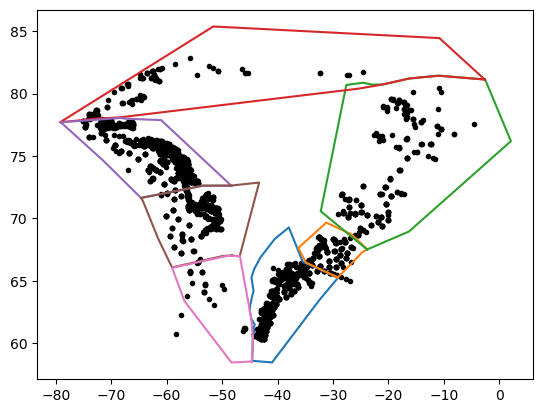

In [17]:
plt.plot(df['Longitude'], df['Latitude'], 'k.')
for region in polygons:
    plt.plot(polygons[region][:,0], polygons[region][:,1])

In [18]:
# Color coding a region example

In [19]:
region = 'N'

# make a path called p
p = mplPath.Path(polygons[region])

# use the path to sample if a given point is inside
all_points = np.column_stack([df['Longitude'], df['Latitude']])
inside = p.contains_points(all_points)

# 
df_region = df[inside]

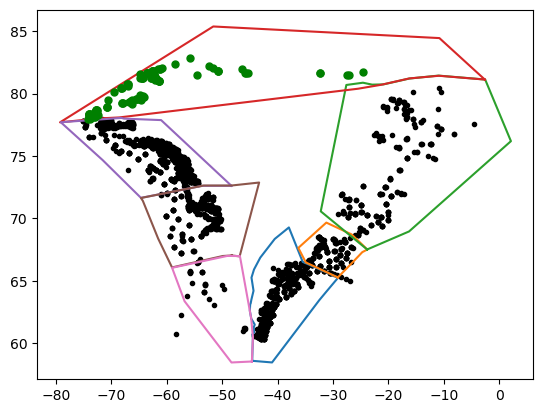

In [20]:
plt.plot(df['Longitude'], df['Latitude'], 'k.')
for region in polygons:
    plt.plot(polygons[region][:,0], polygons[region][:,1])
plt.plot(df_region['Longitude'], df_region['Latitude'], 'g.', markersize=10)

### Now that I can isolate the omg points in their regions, I need to iterate through the csv, check the lon and lat, and see which region they're in

In [21]:
temps_csv = pd.read_csv('/Users/sherine_aldrin/Downloads/CoOL/ORAS5/Temp_ORAS5_Profiles.csv')
temps_csv.head()

,CTD_file,Var_type,ORAS5 lon(X),ORAS5 lat(Y),OMG lon(X),OMG lat(Y),Distance,Year,Month,Profile
0,CTD_20160916_140334.nc,Theta,-65.157410,74.696080,-65.246246,74.732773,4.840273,2016,9,"[3.2723419666290283, 3.267146587371826, 3.2632..."
1,CTD_20160923_153439.nc,Theta,-64.799130,81.217080,-64.780159,81.222504,0.684310,2016,9,"[-1.5203176736831665, -1.5193787813186646, -1...."
2,CTD_20160914_145226.nc,Theta,-52.532910,69.155700,-52.412819,69.198280,6.704399,2016,9,"[5.195065021514893, 5.195621967315674, 5.19637..."
3,CTD_20160924_155359.nc,Theta,-61.277233,73.705666,-61.269279,73.738861,3.699407,2016,9,"[4.5973334312438965, 4.594786167144775, 4.5931..."
4,CTD_20160928_133513.nc,Theta,-58.345640,74.045364,-58.261341,74.033386,2.901395,2016,9,"[3.8334763050079346, 3.828251600265503, 3.8234..."


In [22]:
OMGlon = temps_csv['OMG lon(X)']
OMGlat = temps_csv['OMG lat(Y)']

print(OMGlon[3])
print(OMGlat[3])

-61.26927947998047
73.73886108398438


#### for each omg coordinate, assign it to a region and add a column to a final csv

In [23]:
# read in the polygons from the shapefile 
polygons = {}
sf = shapefile.Reader(shapefile_path)
for s, shape in enumerate(sf.shapes()):
    region = sf.records()[s][0]
    polygons[region] = np.array(shape.points)

# Assign region to each CTD point
df = pd.read_csv(omg_loc_path)  # this has File_ID, Lat, Lon, etc.
all_points = np.column_stack([df['Longitude'], df['Latitude']])
region_labels = []

for lon, lat in all_points:
    assigned = False
    for region, poly in polygons.items():
        path = mplPath.Path(poly)
        if path.contains_point((lon, lat)):
            region_labels.append(region)
            assigned = True
            break
    if not assigned:
        region_labels.append("Unassigned")

df['Region'] = region_labels

# Save the updated file
df.to_csv('/Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_CTD_Locations_regional.csv', index=False)
print("Saved updated CTD location file with region labels.")


Saved updated CTD location file with region labels.


### Actually make the histogram

In [24]:
# Paths
oras_temp_csv = "Temp_ORAS5_Profiles.csv"
oras_salt_csv = "Salt_ORAS5_Profiles.csv"
ctd_base_path = "/Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_data"
omg_loc_path = '/Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_CTD_Locations.csv'
shapefile_path = '/Users/sherine_aldrin/Downloads/CoOL/ORAS5/sample_polygons/sample_polygons'
region_output = '/Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_CTD_Locations_2016_2017_with_region.csv'
output_dir = "oras5_histograms"
os.makedirs(output_dir, exist_ok=True)

# Filter CTD Locations to 2016 & 2017 and Assign Region
df = pd.read_csv(omg_loc_path)
df = df[df['Year'].isin([2016, 2017])].copy()

sf = shapefile.Reader(shapefile_path)
polygons = {sf.records()[s][0]: np.array(shape.points) for s, shape in enumerate(sf.shapes())}

region_labels = []
for lon, lat in zip(df['Longitude'], df['Latitude']):
    assigned = False
    for region, poly in polygons.items():
        path = mplPath.Path(poly)
        if path.contains_point((lon, lat)):
            region_labels.append(region)
            assigned = True
            break
    if not assigned:
        region_labels.append("Unassigned")

df['Region'] = region_labels
df.to_csv(region_output, index=False)
print("Saved:", region_output)

# Load Region Info
region_df = pd.read_csv(region_output)

# Helper Functions
def read_ctd_profile(path, var_type):
    try:
        ds = xr.open_dataset(path)
        if var_type == "Theta":
            values = ds["potential_temperature"].values
        elif var_type == "Salinity":
            values = ds["practical_salinity"].values
        else:
            return None, None
        depths = ds["depth"].values
        ds.close()
        return depths, values
    except:
        return None, None

def clean_profile(profile_string):
    if pd.isna(profile_string):
        return []
    nums = re.findall(r'[-+]?[\d]*\.?[\d]+', profile_string)
    return [float(x) for x in nums if float(x) != 0.0]

def load_oras5_data(csv_path, var_type):
    df = pd.read_csv(csv_path)
    df["Var_type"] = var_type
    df["Profile"] = df["Profile"].apply(clean_profile)
    return df

# Load ORAS5 Summary Data
df_temp = load_oras5_data(oras_temp_csv, "Theta")
df_salt = load_oras5_data(oras_salt_csv, "Salinity")
df_all = pd.concat([df_temp, df_salt], ignore_index=True)
df_all["File_ID"] = df_all["CTD_file"].str.replace("CTD_", "", regex=False).str.replace(".nc", "", regex=False)
df_all = df_all.merge(region_df[["File_ID", "Region"]], on="File_ID", how="left")
df_all["Region"] = df_all["Region"].fillna("Unassigned")

# Compute Differences
diffs_by_group = {}
for (region, var_type), group in df_all.groupby(["Region", "Var_type"]):
    key = (region, var_type)
    region_diffs = []

    for _, row in group.iterrows():
        ctd_path = os.path.join(ctd_base_path, row["CTD_file"])
        if not os.path.exists(ctd_path):
            continue

        oras_profile = np.array(row["Profile"])
        ctd_depths, ctd_values = read_ctd_profile(ctd_path, var_type)

        if (
            oras_profile is None or len(oras_profile) == 0 or
            ctd_values is None or len(ctd_values) == 0 or
            ctd_depths is None or len(ctd_depths) == 0
        ):
            continue

        interp_len = min(len(oras_profile), len(ctd_values))
        common_depths = np.linspace(ctd_depths.min(), ctd_depths.max(), interp_len)
        ctd_interp = np.interp(common_depths, ctd_depths, ctd_values)
        oras_interp = np.interp(common_depths,
                                np.linspace(ctd_depths.min(), ctd_depths.max(), len(oras_profile)),
                                oras_profile)

        region_diffs.extend(oras_interp - ctd_interp)

    diffs_by_group[key] = region_diffs

# Plotting with GridSpec
region_positions = {
    "N": (0, 0), "NW": (1, 0), "CW": (2, 0), "SW": (3, 0),
    "NE": (0, 1), "CE": (1, 1), "SE": (2, 1)
}
regions = list(region_positions.keys())

for var_type in ["Theta", "Salinity"]:
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(f"{var_type} Differences Across Regions (ORAS5 - CTD)", fontsize=16)
    gs = gridspec.GridSpec(4, 2, figure=fig)

    for region in regions:
        row, col = region_positions[region]
        ax = fig.add_subplot(gs[row, col])
        key = (region, var_type)
        diffs = diffs_by_group.get(key, [])

        if not diffs:
            ax.set_title(f"{region} (No Data)")
            ax.axis("off")
            continue

        diffs = np.array(diffs)
        diffs = diffs[~np.isnan(diffs)]
        diffs = diffs[np.abs(diffs) < 5]  # remove extreme outliers

        if len(diffs) == 0:
            ax.set_title(f"{region} (No Valid Data)")
            ax.axis("off")
            continue

        mean_diff = np.mean(diffs)
        ax.hist(diffs, bins=50, color="black", edgecolor="skyblue")
        ax.axvline(mean_diff, color="red", linestyle="--", label=f"Mean = {mean_diff:.2f}")
        ax.set_title(region)
        ax.set_xlabel("ORAS5 - CTD")
        ax.set_ylabel("Count")
        ax.grid(True)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f"ORAS5_{var_type}_hist_by_region.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.close()

print(f"Saved plots to: {output_dir}")


Saved: /Users/sherine_aldrin/Downloads/CoOL/ORAS5/OMG_CTD_Locations_2016_2017_with_region.csv
Saved plots to: oras5_histograms
